In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, f1_score, fbeta_score, make_scorer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.compose import make_column_transformer

from xgboost import XGBClassifier



pd.set_option('display.float_format', lambda x: '%.2f' % x)
RSEED = 42

In [2]:
df = pd.read_csv('data/cleaned/train_extended.csv')
df_test = pd.read_csv('data/cleaned/test_extended.csv')
df.head()


,district,client_id,client_catg,region,reading_remarque_6,reading_remarque_7,reading_remarque_8,reading_remarque_9,reading_remarque_413,counter_statue_0,...,counter_coefficient_30,counter_coefficient_33,counter_coefficient_40,counter_coefficient_50,counter_code_count_unique,counter_number_count_unique,counter_type_count_unique,months_number,consommation_sum,target
0,60,train_Client_29310,11,101,18,0,6,34,0,56,...,0,0,0,0,2,3,2,3.93,734.81,0.00
1,63,train_Client_128477,11,312,1,0,2,1,0,4,...,0,0,0,0,1,1,1,3.50,325.75,0.00
2,63,train_Client_56966,11,311,40,0,15,23,0,78,...,0,0,0,0,2,2,2,4.21,537.35,0.00
3,69,train_Client_23694,11,104,0,0,3,17,0,20,...,0,0,0,0,2,2,2,4.00,762.45,0.00
4,62,train_Client_12064,11,309,2,0,0,24,0,26,...,0,0,0,0,2,2,2,4.00,375.73,0.00


## Split Target, Drop ID

In [3]:
y_train = df['target']
X_train = df.drop(['target', 'client_id'], axis=1)

In [5]:
# Helper (compare X_train and X_test below):
X_train.head(2)

,district,client_catg,region,reading_remarque_6,reading_remarque_7,reading_remarque_8,reading_remarque_9,reading_remarque_413,counter_statue_0,counter_statue_1,...,counter_coefficient_20,counter_coefficient_30,counter_coefficient_33,counter_coefficient_40,counter_coefficient_50,counter_code_count_unique,counter_number_count_unique,counter_type_count_unique,months_number,consommation_sum
0,60,11,101,18,0,6,34,0,56,1,...,0,0,0,0,0,2,3,2,3.93,734.81
1,63,11,312,1,0,2,1,0,4,0,...,0,0,0,0,0,1,1,1,3.50,325.75


In [11]:
# Helper column names
X_train.columns

Index(['district', 'client_catg', 'region', 'reading_remarque_6',
       'reading_remarque_7', 'reading_remarque_8', 'reading_remarque_9',
       'reading_remarque_413', 'counter_statue_0', 'counter_statue_1',
       'counter_statue_2', 'counter_statue_3', 'counter_statue_4',
       'counter_statue_5', 'counter_statue_13', 'counter_statue_618',
       'tarif_type_8', 'tarif_type_9', 'tarif_type_10', 'tarif_type_11',
       'tarif_type_12', 'tarif_type_13', 'tarif_type_14', 'tarif_type_15',
       'tarif_type_18', 'tarif_type_21', 'tarif_type_24', 'tarif_type_27',
       'tarif_type_29', 'tarif_type_30', 'tarif_type_40', 'tarif_type_42',
       'tarif_type_45', 'counter_coefficient_0', 'counter_coefficient_1',
       'counter_coefficient_2', 'counter_coefficient_3',
       'counter_coefficient_4', 'counter_coefficient_5',
       'counter_coefficient_6', 'counter_coefficient_9',
       'counter_coefficient_10', 'counter_coefficient_11',
       'counter_coefficient_20', 'counter_coefficie

In [9]:
#Split target from test data
y_test = df_test['target']
X_test = df_test.drop(['target', 'client_id'], axis=1)

In [10]:
# Helper (compare X_train and X_test):
X_test.head(2)

,district,client_catg,region,reading_remarque_6,reading_remarque_7,reading_remarque_8,reading_remarque_9,reading_remarque_413,counter_statue_0,counter_statue_1,...,counter_coefficient_20,counter_coefficient_30,counter_coefficient_33,counter_coefficient_40,counter_coefficient_50,counter_code_count_unique,counter_number_count_unique,counter_type_count_unique,months_number,consommation_sum
0,69,11,104,26,0,3,23,0,52,0,...,0,0,0,0,0,2,2,2,4.08,387.98
1,69,11,104,2,0,0,0,0,2,0,...,0,0,0,0,0,2,2,2,4.00,826.50


## Scaling the data

In [12]:
# numerical features
num_features = [ 'consommation_sum', 'months_number']
num_transformer = make_pipeline(
        MinMaxScaler() # no gaussian distribution? 
    )

In [13]:
preprocessor = make_column_transformer(
        (num_transformer, num_features)
)

## Hybrid Sampling (Undersampling of Non-Fraud and Oversampling of Fraud cases)

In [14]:
# SMOTE + ENN (Noise Reduction)
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

In [32]:
# 1. Under sampling of the majority
#under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Reduces 50% of the Non-Fraud cases
#X_train_undersampled, y_train_undersampled = under.fit_resample(X_train, y_train)

# 2. Over sampling of the minority
#smote = SMOTE(sampling_strategy=0.7, random_state=42)  # brings the minority class to 70% of the majority
#X_train_resampled, y_resampled = smote.fit_resample(X_train_undersampled, y_train_undersampled)

In [15]:
X_resampled.shape

(159375, 53)

In [16]:
y_resampled.shape

(159375,)

In [27]:
# handling the imbalanced
#ros = RandomOverSampler(random_state=RSEED)
#X_train, y_train = ros.fit_resample(X_train, y_train)

#sns.countplot(x=y_resampled)

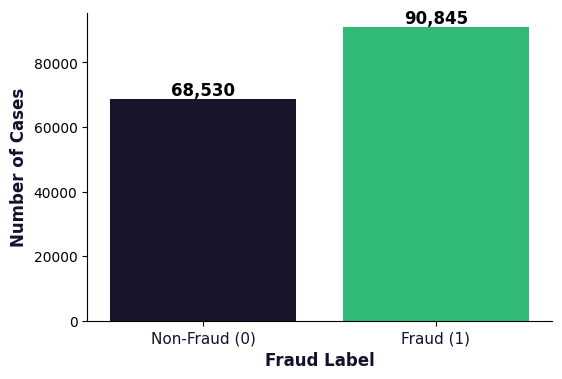

In [29]:
# Choosing the colors
custom_palette = ['#13122d', '#1ad079']

# Creating the plot
plt.figure(figsize=(6,4))
ax = sns.countplot(x=y_resampled, palette=custom_palette)

# Showing values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Axis & format
ax.set_xlabel("Fraud Label", fontsize=12, fontweight='bold', color='#13122d')
ax.set_ylabel("Number of Cases", fontsize=12, fontweight='bold', color='#13122d')
ax.set_xticklabels(["Non-Fraud (0)", "Fraud (1)"], fontsize=11, color='#13122d')

# Remove the top and right frame
sns.despine()

# Show the graph
plt.show()

## HyperparameterSearch & Scoring


In [38]:
#scoring = make_scorer(fbeta_score, beta=2)
scoring = 'roc_auc'
cv = 5 #RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

## Model 1: Random Forest

#### with RandomizedSearch


In [39]:
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=RSEED))]
)

In [40]:
# don't forget to add the name of the model from the pipelin in front of each hyperparameter!
param_rf = {'rf__n_estimators': [50, 100, 500, 750, 1000],
    'rf__max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'rf__max_leaf_nodes': [None] + list(np.arange(10, 51).astype(int)),
    'rf__min_samples_split': [2, 5, 10],
    'rf__max_depth': [None] + [3, 10, 50, 100],
    'rf__bootstrap': [True, False],
    'rf__criterion': ['entropy', 'gini']
    }

randomsearch_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_rf, cv=cv, scoring=scoring, n_iter=10,
                           verbose=5, n_jobs=-1) #evt. add error_score='raise'

In [41]:
randomsearch_rf.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('pipeline',
                                                                               Pipeline(steps=[('minmaxscaler',
                                                                                                MinMaxScaler())]),
                                                                               ['consommation_sum',
                                                                                'months_number'])])),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__criterion': ['entropy', 'gini'],
                                        'rf__max_depth': [None, 3, 10, 50, 100],
                                        'rf__max_features': ['auto', 'sqrt',
                                                             None, 0.5, 0.6,
                                                             0.7,
                                                             0.7999999999999999,
                                                             0.8999999999999999],
                                        'rf__max_leaf_nodes': [None, 10, 11, 12,
                                                               13, 14, 15, 16,
                                                               17, 18, 19, 20,
                                                               21, 22, 23, 24,
                                                               25, 26, 27, 28,
                                                               29, 30, 31, 32,
                                                               33, 34, 35, 36,
                                                               37, 38, ...],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [50, 100, 500, 750,
                                                             1000]},
                   scoring='roc_auc', verbose=5)

In [42]:
# Show best parameters
print('Best score:\n{:.2f}'.format(randomsearch_rf.best_score_))
print("Best parameters:\n{}".format(randomsearch_rf.best_params_))

Best score:
0.78
Best parameters:
{'rf__n_estimators': 100, 'rf__min_samples_split': 10, 'rf__max_leaf_nodes': 49, 'rf__max_features': None, 'rf__max_depth': 50, 'rf__criterion': 'gini', 'rf__bootstrap': True}


In [43]:
# Save best model (including fitted preprocessing steps) as best_model_rf 
best_model_rf = randomsearch_rf.best_estimator_
best_model_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['consommation_sum',
                                                   'months_number'])])),
                ('rf',
                 RandomForestClassifier(max_depth=50, max_features=None,
                                        max_leaf_nodes=49, min_samples_split=10,
                                        random_state=42))])

In [44]:
# Make predictions for X_train
train_probs_1 = best_model_rf.predict_proba(X_train)[:, 1]
train_predictions_1 = best_model_rf.predict(X_train)

# Results X_train prediction:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs_1)}')
print(confusion_matrix(y_train, train_predictions_1))
print(classification_report(y_train, train_predictions_1))

Train ROC AUC Score: 0.6342764022857494
[[36717 59183]
 [  998  4676]]
              precision    recall  f1-score   support

         0.0       0.97      0.38      0.55     95900
         1.0       0.07      0.82      0.13      5674

    accuracy                           0.41    101574
   macro avg       0.52      0.60      0.34    101574
weighted avg       0.92      0.41      0.53    101574



In [ ]:
# make predictions for X-test
test_probs_1 = best_model_rf.predict_proba(X_test)[:, 1]
test_predictions_1 = best_model_rf.predict(X_test)

# Results X_test prediction:
print(f'Test ROC AUC Score: {roc_auc_score(y_test, test_probs_1)}')
print(confusion_matrix(y_test, test_predictions_1))
print(classification_report(y_test, test_predictions_1))

Test ROC AUC Score: 0.6199328790715622
[[12199 19769]
 [  375  1516]]
              precision    recall  f1-score   support

         0.0       0.97      0.38      0.55     31968
         1.0       0.07      0.80      0.13      1891

    accuracy                           0.41     33859
   macro avg       0.52      0.59      0.34     33859
weighted avg       0.92      0.41      0.52     33859



In [49]:
# Making a list with the results for plotting

rf_metrics = np.array([accuracy_score(y_test, test_predictions_1), precision_score(y_test, test_predictions_1), recall_score(y_test, test_predictions_1), f1_score(y_test, test_predictions_1)]).round(2)
rf_metrics

array([0.41, 0.07, 0.8 , 0.13])

In [60]:
# Compute FPR and TPR for the model to plot the roc_curve
fpr_values_rf, tpr_values_rf, _ = roc_curve(y_test, test_probs_1)  # Probability of class 1

np.save("fpr_values_rf.npy", fpr_values_rf)
np.save("tpr_values_rf.npy", tpr_values_rf)

print(fpr_values_rf)
print(tpr_values_rf)

[0.00000000e+00 1.25125125e-04 2.50250250e-04 ... 9.44507007e-01
 9.88770020e-01 1.00000000e+00]
[0.         0.00105764 0.00105764 ... 0.98889476 0.99101005 1.        ]


#### Without GridSearch

In [ ]:
# Create the model with 1000 trees
model1 = RandomForestClassifier(n_estimators=1000, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model1.fit(X_train, y_train)

In [ ]:
# Make predictions for X_train
train_probs_1 = model1.predict_proba(X_train)[:, 1]
train_predictions_1 = model1.predict(X_train)

In [ ]:
# Results X_train prediction:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs_1)}')
print(confusion_matrix(y_train, train_predictions_1))
print(classification_report(y_train, train_predictions_1))

In [ ]:
# Make predictions for X_test
test_probs_1 = model1.predict_proba(X_test)[:, 1]
test_predictions_1 = model1.predict(X_test)

In [ ]:
# Results X_test prediction:
print(f'Test ROC AUC Score: {roc_auc_score(y_test, test_probs_1)}')
print(confusion_matrix(y_test, test_predictions_1))
print(classification_report(y_test, test_predictions_1))